# prox c-02 Script 18 - Final result tests

__Notebooks starting with "prox c-" integrate new processes and methodologies for calculating proximity. Based on the develop of proximity 2024 (Script 21-proximity-analysis-mexico.py)__

This notebook compares the output (test_mode, Aguascalientes) of script 18 (proximity-analysis-for-aoi) vs the data that's already in the database as of 05 2024 (nodes_proximity_2020 and time_15_min_analysis_hexres8).

Last test (2024 06 05) results:
1. Time differences by node and hex, success (__Expected time differences in nodes outside state boundaries due to different edges['time_min'].fillna() approach.__ Explanation in Miro.).
2. Differences in pobtot and dens_pob_ha are due to the fact that table "time_15_min_analysis_hexres8" [output from Script 15], uses "hex_bins_pop_2020" [from Script 02]. Script 02 uses AGEB data to nodes, while Script 18 uses BLOCK data [function analysis > create_popdata_hexgrid()].

## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

<Axes: >

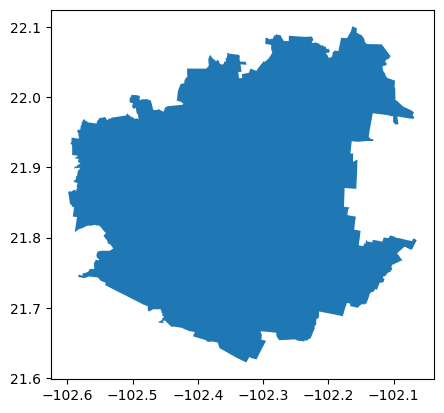

In [17]:
# Area of interest (city)
city = 'Aguascalientes'
metro_schema = 'metropolis'
metro_table = 'metro_gdf_2015'

# Downloads hexagons within 'city'
query = f"SELECT * FROM {metro_schema}.{metro_table} WHERE \"city\" LIKE \'{city}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')

mun_gdf = mun_gdf.set_crs("EPSG:4326")
aoi = mun_gdf.dissolve()

#Show
aoi.plot()

In [18]:
G, nodes, edges = aup.graph_from_hippo(aoi, 'osmnx', 'edges_speed', 'nodes')

In [21]:
test_1 = edges.loc[edges.time_min.isna()]

# Show
print(test_1.shape)
test_1.head(1)

(72, 19)


,,,osmid,oneway,lanes,name,highway,length,geometry,grade,grade_abs,access,tunnel,ref,maxspeed,bridge,junction,service,width,walkspeed,time_min
u,v,key,,,,,,,,,,,,,,,,,,,
6470661403,8553072241,0,689721332,False,None,None,unclassified,388.911,"LINESTRING (-102.32393 21.63140, -102.32148 21...",NaN,NaN,None,None,None,None,None,None,None,None,NaN,NaN


In [25]:
edges_edit = edges.copy()

no_length = len(edges_edit.loc[edges_edit['length'].isna()])
edges_edit = edges_edit.to_crs("EPSG:6372")
edges_edit['length'].fillna(edges_edit.length,inplace=True)
edges_edit = edges_edit.to_crs("EPSG:4326")

print(f"Calculated length for {no_length} edges that had no length data.")

Calculated length for 0 edges that had no length data.


In [26]:
prox_measure = 'time_min'

# If prox_measure = 'length', calculates time_min assuming walking speed = 4km/hr
if prox_measure == 'length':
    edges_edit['time_min'] = (edges_edit['length']*60)/4000
else:
    # NaNs in time_min? --> Assume walking speed = 4km/hr
    no_time = len(edges_edit.loc[edges_edit['time_min'].isna()])
    edges_edit['time_min'].fillna((edges_edit['length']*60)/4000,inplace=True)
    print(f"Calculated time for {no_time} edges that had no time data.")

Calculated time for 72 edges that had no time data.


## Script 18 test mode configuration (info)

In [2]:
### Test data was created on Script 18 using the following configuration: 

# Directories (From Notebook prox a-00-Required_data)
#aoi_dir = "../data/external/temporal_todocker/prox_aoi/aoi_ags.gpkg"
#pois_dir = "../data/external/temporal_todocker/prox_aoi/pois_ags.gpkg"
#pop_dir = "../data/external/temporal_todocker/prox_aoi/pop_gdf_ags.gpkg"

# Resolutions of hexgrid output
#res_list = [8,9]
# Count available amenities at given time proximity (minutes)? (Required)
#count_pois = (False,15) # Must pass a tupple containing a boolean (True or False) and time proximity of interest in minutes (Boolean,time)
##########
# Ran count_pois to confirm it works
# count_pois not available on previous proximity analysis, not comparable
##########
# Save disk space by deleting used data that will not be used after? (Required)
#save_space = True

#database_network = True
#network_schema = 'osmnx' #(Required if database_network = True)
#nodes_table = 'nodes' #(Required if database_network = True)
#edges_table = 'edges_speed' #(Required if database_network = True)

# OPTIONAL - Population data
# pop_output = True
# pop_columns = ['pobtot','pobfem','pobmas']
# pop_index_column = 'cvegeo'

# Same parameters dict and weights dict as established on Script 21 for regular (v1) proximity analysis.

## Nodes test

### Load test data

In [3]:
# Location of nodes prox (From Script 18 Aguascalientes test)
nodes_dir = "../../../data/processed/prox_aoi/test_script18_Aguascalientes_nodes.gpkg"
nodes_prox_test = gpd.read_file(nodes_dir)

# Show
print(nodes_prox_test.shape)
print(nodes_prox_test.crs)
nodes_prox_test.head(1)

(51434, 64)
EPSG:4326


,osmid,denue_preescolar,denue_preescolar_15min,denue_primaria,denue_primaria_15min,denue_secundaria,denue_secundaria_15min,clues_primer_nivel,clues_primer_nivel_15min,denue_guarderias,...,sip_espacio_publico_15min,denue_parque_natural,denue_parque_natural_15min,denue_cines,denue_cines_15min,denue_museos,denue_museos_15min,x,y,geometry
0,272921360,10.770629,2.0,5.615674,2.0,11.812107,1.0,6.486561,4.0,5.09561,...,3.0,None,None,26.069111,0.0,7.589368,1.0,-102.295073,21.872876,POINT (-102.29507 21.87288)


### Load current database data

In [4]:
schema = 'prox_analysis'
table = 'nodes_proximity_2020'
city = 'Aguascalientes'

query = f"SELECT * FROM {schema}.{table} WHERE \"metropolis\" LIKE \'{city}\'"
nodes_prox_db = aup.gdf_from_query(query, geometry_col='geometry')

#Show
print(nodes_prox_db.shape)
nodes_prox_db.head(2)

(2208953, 7)


,osmid,x,y,geometry,time,amenity,metropolis
0,272921360,-102.295073,21.872876,POINT (-102.29507 21.87288),10.770629,denue_preescolar,Aguascalientes
1,301191867,-102.274442,21.937135,POINT (-102.27444 21.93714),18.819849,denue_preescolar,Aguascalientes


### Transform current database data (from tidy data to node-by-row)

In [5]:
# Transform original nodes data (rows to columns)
nodes_prox_db_t = nodes_prox_db.drop_duplicates(subset='osmid', keep="last")[['osmid','geometry','metropolis']].copy()
for amenidad in list(nodes_prox_db.amenity.unique()):
    nodes_tmp = nodes_prox_db.loc[nodes_prox_db.amenity == amenidad,['osmid','time']]
    nodes_tmp = nodes_tmp.rename(columns={'time':amenidad})

    if nodes_tmp[amenidad].mean() == 0:
        nodes_tmp[amenidad] = np.nan

    nodes_prox_db_t = nodes_prox_db_t.merge(nodes_tmp, on='osmid')

# Show
print(nodes_prox_db_t.shape)
nodes_prox_db_t.head(1)

(51371, 46)


,osmid,geometry,metropolis,denue_preescolar,denue_primaria,denue_secundaria,denue_escuela_mixta,denue_casa_adultos_mayores,denue_guarderias,denue_dif,...,sip_cancha,sip_unidad_deportiva,sip_espacio_publico,sip_mercado,clues_primer_nivel,clues_segundo_nivel,clues_tercer_nivel,sigade_preescolar,sigade_primaria,sigade_secundaria
0,272921360,POINT (-102.29507 21.87288),Aguascalientes,10.770629,5.615674,11.812107,5.25473,9.729402,5.09561,6.486561,...,156.885198,28.44305,5.692959,22.145997,6.486561,6.486561,53.636174,3.327789,3.327789,3.327789


In [6]:
# Note: There are no parques naturales in Aguascalientes
nodes_prox_db_t.denue_parque_natural.unique()

array([nan])

### Compare nodes proximity

#### Remove count pois columns from newer analysis

In [7]:
list(nodes_prox_test.columns)

['osmid',
 'denue_preescolar',
 'denue_preescolar_15min',
 'denue_primaria',
 'denue_primaria_15min',
 'denue_secundaria',
 'denue_secundaria_15min',
 'clues_primer_nivel',
 'clues_primer_nivel_15min',
 'denue_guarderias',
 'denue_guarderias_15min',
 'denue_dif',
 'denue_dif_15min',
 'denue_supermercado',
 'denue_supermercado_15min',
 'denue_abarrotes',
 'denue_abarrotes_15min',
 'denue_carnicerias',
 'denue_carnicerias_15min',
 'sip_mercado',
 'sip_mercado_15min',
 'denue_peluqueria',
 'denue_peluqueria_15min',
 'denue_farmacias',
 'denue_farmacias_15min',
 'denue_ferreteria_tlapaleria',
 'denue_ferreteria_tlapaleria_15min',
 'denue_art_limpieza',
 'denue_art_limpieza_15min',
 'denue_ropa',
 'denue_ropa_15min',
 'denue_calzado',
 'denue_calzado_15min',
 'denue_muebles',
 'denue_muebles_15min',
 'denue_lavanderia',
 'denue_lavanderia_15min',
 'denue_revistas_periodicos',
 'denue_revistas_periodicos_15min',
 'denue_pintura',
 'denue_pintura_15min',
 'denue_restaurante_insitu',
 'denue_r

In [8]:
remove_count_cols = ['denue_preescolar_15min', 'denue_primaria_15min', 'denue_secundaria_15min',
                     'clues_primer_nivel_15min', 'denue_guarderias_15min', 'denue_dif_15min',
                     'denue_supermercado_15min', 'denue_abarrotes_15min', 'denue_carnicerias_15min',
                     'sip_mercado_15min', 'denue_peluqueria_15min', 'denue_farmacias_15min',
                     'denue_ferreteria_tlapaleria_15min', 'denue_art_limpieza_15min','denue_ropa_15min', 
                     'denue_calzado_15min', 'denue_muebles_15min','denue_lavanderia_15min', 
                     'denue_revistas_periodicos_15min', 'denue_pintura_15min', 'denue_restaurante_insitu_15min',
                     'denue_restaurante_llevar_15min', 'denue_bares_15min','denue_cafe_15min', 'sip_cancha_15min',
                     'sip_unidad_deportiva_15min','sip_espacio_publico_15min','denue_parque_natural_15min', 
                     'denue_cines_15min',  'denue_museos_15min']
nodes_prox_test.drop(columns=remove_count_cols,inplace=True)
list(nodes_prox_test.columns)

['osmid',
 'denue_preescolar',
 'denue_primaria',
 'denue_secundaria',
 'clues_primer_nivel',
 'denue_guarderias',
 'denue_dif',
 'denue_supermercado',
 'denue_abarrotes',
 'denue_carnicerias',
 'sip_mercado',
 'denue_peluqueria',
 'denue_farmacias',
 'denue_ferreteria_tlapaleria',
 'denue_art_limpieza',
 'denue_ropa',
 'denue_calzado',
 'denue_muebles',
 'denue_lavanderia',
 'denue_revistas_periodicos',
 'denue_pintura',
 'denue_restaurante_insitu',
 'denue_restaurante_llevar',
 'denue_bares',
 'denue_cafe',
 'sip_cancha',
 'sip_unidad_deportiva',
 'sip_espacio_publico',
 'denue_parque_natural',
 'denue_cines',
 'denue_museos',
 'x',
 'y',
 'geometry']

#### Fields to compare (time cols)

In [9]:
# Create attributes list which will be compared by node
nodes_attributes_list = list(nodes_prox_test.columns)
nodes_attributes_list.remove('osmid')
nodes_attributes_list.remove('x')
nodes_attributes_list.remove('y')
nodes_attributes_list.remove('geometry')
nodes_attributes_list

['denue_preescolar',
 'denue_primaria',
 'denue_secundaria',
 'clues_primer_nivel',
 'denue_guarderias',
 'denue_dif',
 'denue_supermercado',
 'denue_abarrotes',
 'denue_carnicerias',
 'sip_mercado',
 'denue_peluqueria',
 'denue_farmacias',
 'denue_ferreteria_tlapaleria',
 'denue_art_limpieza',
 'denue_ropa',
 'denue_calzado',
 'denue_muebles',
 'denue_lavanderia',
 'denue_revistas_periodicos',
 'denue_pintura',
 'denue_restaurante_insitu',
 'denue_restaurante_llevar',
 'denue_bares',
 'denue_cafe',
 'sip_cancha',
 'sip_unidad_deportiva',
 'sip_espacio_publico',
 'denue_parque_natural',
 'denue_cines',
 'denue_museos']

#### Random individual differences

In [10]:
#nodes_prox_db_t.loc[nodes_prox_db_t.osmid==842077165].head(1)

In [11]:
#nodes_prox_test.loc[nodes_prox_test.osmid==842077165].head(1)

#### Sum of all differences

In [12]:
# Inner merge (to compare same osmids)
nodes_compare = nodes_prox_db_t.merge(nodes_prox_test,on='osmid',how='inner')
nodes_compare.drop(columns=['geometry_x'],inplace=True)
nodes_compare.rename(columns={'geometry_y':'geometry'},inplace=True)

# Compare old and new amenities
nodes_compare_list = []
for attribute in nodes_attributes_list:

    old_attribute = f"{attribute}_x"
    new_attribute = f"{attribute}_y"
    nodes_compare[f"{attribute}_diff"] = nodes_compare[new_attribute] - nodes_compare[old_attribute]

    nodes_compare_list.append(f"{attribute}_diff")

# Visualize sum of attribute value differences (sum of each _diff col values)
nodes_summary = pd.DataFrame()
i = 0
for compared_attribute in nodes_compare_list:

    diff_value = nodes_compare[compared_attribute].sum()
    nodes_summary.loc[i,'attribute'] = compared_attribute
    nodes_summary.loc[i,'diff'] = diff_value

    i = i+1

nodes_summary['rounded_diff'] = round(nodes_summary['diff'],4)

# Note that denue_parque_natural_diff is 0 because there are no parques naturales in Aguascalientes

# Show
nodes_summary

,attribute,diff,rounded_diff
0,denue_preescolar_diff,865.586742,865.5867
1,denue_primaria_diff,865.586742,865.5867
2,denue_secundaria_diff,865.586742,865.5867
3,clues_primer_nivel_diff,865.586742,865.5867
4,denue_guarderias_diff,865.586742,865.5867
5,denue_dif_diff,865.586742,865.5867
6,denue_supermercado_diff,865.586742,865.5867
7,denue_abarrotes_diff,865.586742,865.5867
8,denue_carnicerias_diff,865.586742,865.5867
9,sip_mercado_diff,865.586742,865.5867


#### Nodes with differences (Expecting them to be outside state boundaries due to different time_min calculation methods.)

In [13]:
test = nodes_compare.copy()
test['tot_diff'] = test[nodes_compare_list].sum(axis=1)
problems = test.loc[test['tot_diff']>0][['denue_preescolar_x','denue_preescolar_y','geometry']]
problems_gdf = gpd.GeoDataFrame(problems)

# Show
print(problems_gdf.shape)
problems_gdf

(29, 3)


,denue_preescolar_x,denue_preescolar_y,geometry
6481,393.307912,419.872010,POINT (-102.52214 21.71798)
28520,238.867880,305.676048,POINT (-102.41263 21.64562)
28537,320.264615,330.771543,POINT (-102.43913 21.66603)
30219,366.023023,373.465420,POINT (-102.09110 21.78048)
31268,192.292426,202.862653,POINT (-102.34348 21.62326)
31278,192.292426,209.816023,POINT (-102.32627 21.62253)
31279,193.999173,212.450563,POINT (-102.32534 21.62382)
31784,95.342728,110.655731,POINT (-102.28757 21.66278)
31792,106.072205,202.487236,POINT (-102.22683 21.65927)
31793,109.703936,206.118966,POINT (-102.22721 21.66054)


<Axes: >

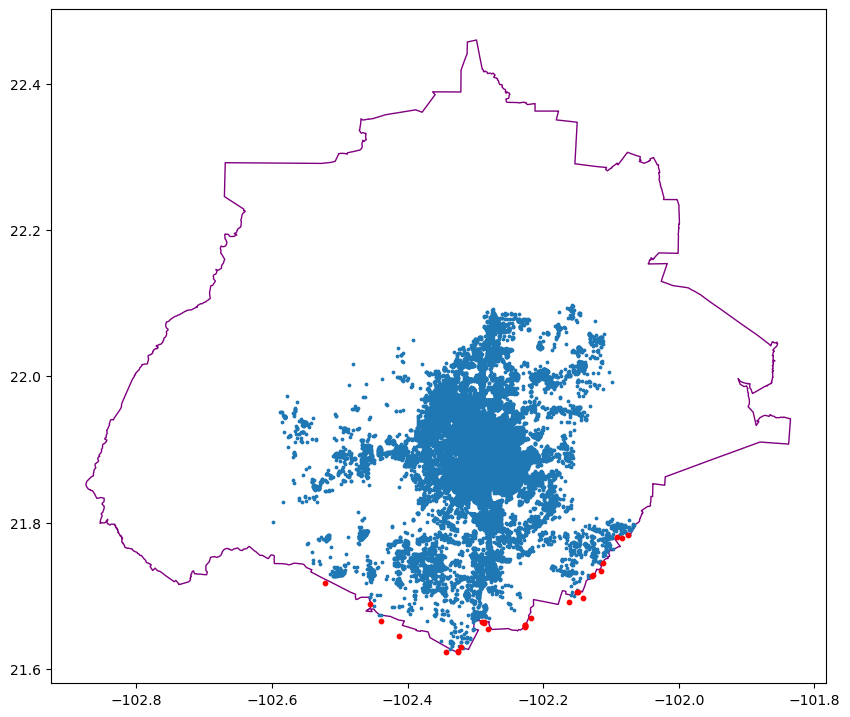

In [51]:
# State boundaries
cve_ent = '01'
mun_schema = 'marco'
mun_table = 'mpos_2020'

# Download municipalities and create state boundaries
query = f"SELECT * FROM {mun_schema}.{mun_table} WHERE \"CVE_ENT\" = \'{cve_ent}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')
mun_gdf = mun_gdf.to_crs("EPSG:6372").buffer(5)
mun_gdf = gpd.GeoDataFrame(geometry=mun_gdf)
mun_gdf = mun_gdf.to_crs("EPSG:4326")
state_boundaries = mun_gdf.dissolve()

# Show
fig,ax = plt.subplots(figsize=(10,10))
problems_gdf.plot(ax=ax,zorder=2,markersize=10,color='red')
nodes_prox_db_t.plot(ax=ax,zorder=1,markersize=3)
state_boundaries.plot(ax=ax,zorder=0,facecolor='None',edgecolor='purple',linewidth=1)

#### Size of attribute value's difference by node

In [24]:
# How much is the difference between old and new attribute values by node?
# Output table shows the number of nodes with __mins of difference between database data and new (test) data.
differences_to_analyse = [120,60,30,10,5,1,0.0000000001,0.000000000000001,0.000000000000000000000000000001]

# Meaning, How many nodes have a difference of (for example, 1) between old and new data?

nodes_diff_df = pd.DataFrame()

for dif_range in differences_to_analyse:
    i = 0
    for diff_col in nodes_compare_list:
        nodes_diff_df.loc[i,'attribute'] = diff_col
        
        nodes_with_positive_diff = nodes_compare.loc[(nodes_compare[diff_col]>dif_range)].shape[0]
        nodes_with_negative_diff = nodes_compare.loc[(nodes_compare[diff_col]<-dif_range)].shape[0]

        nodes_diff_df.loc[i,f"{dif_range}mins_diff"] = nodes_with_positive_diff
        nodes_diff_df.loc[i,f"{-dif_range}mins_diff"] = nodes_with_negative_diff

        i = i+1

# Note: There are +51,000 nodes in Aguascalientes
nodes_diff_df

,attribute,120mins_diff,-120mins_diff,60mins_diff,-60mins_diff,30mins_diff,-30mins_diff,10mins_diff,-10mins_diff,5mins_diff,-5mins_diff,1mins_diff,-1mins_diff,1e-10mins_diff,-1e-10mins_diff,1e-15mins_diff,-1e-15mins_diff,1e-30mins_diff,-1e-30mins_diff
0,denue_preescolar_diff,0.0,0.0,7.0,0.0,8.0,0.0,20.0,0.0,22.0,0.0,24.0,0.0,29.0,1.0,29.0,1.0,29.0,1.0
1,denue_primaria_diff,0.0,0.0,7.0,0.0,8.0,0.0,20.0,0.0,22.0,0.0,24.0,0.0,29.0,1.0,29.0,1.0,29.0,1.0
2,denue_secundaria_diff,0.0,0.0,7.0,0.0,8.0,0.0,20.0,0.0,22.0,0.0,24.0,0.0,29.0,1.0,29.0,1.0,29.0,1.0
3,clues_primer_nivel_diff,0.0,0.0,7.0,0.0,8.0,0.0,20.0,0.0,22.0,0.0,24.0,0.0,29.0,1.0,29.0,1.0,29.0,1.0
4,denue_guarderias_diff,0.0,0.0,7.0,0.0,8.0,0.0,20.0,0.0,22.0,0.0,24.0,0.0,29.0,1.0,29.0,1.0,29.0,1.0
5,denue_dif_diff,0.0,0.0,7.0,0.0,8.0,0.0,20.0,0.0,22.0,0.0,24.0,0.0,29.0,1.0,29.0,1.0,29.0,1.0
6,denue_supermercado_diff,0.0,0.0,7.0,0.0,8.0,0.0,20.0,0.0,22.0,0.0,24.0,0.0,29.0,1.0,29.0,1.0,29.0,1.0
7,denue_abarrotes_diff,0.0,0.0,7.0,0.0,8.0,0.0,20.0,0.0,22.0,0.0,24.0,0.0,29.0,1.0,29.0,1.0,29.0,1.0
8,denue_carnicerias_diff,0.0,0.0,7.0,0.0,8.0,0.0,20.0,0.0,22.0,0.0,24.0,0.0,29.0,1.0,29.0,1.0,29.0,1.0
9,sip_mercado_diff,0.0,0.0,7.0,0.0,8.0,0.0,20.0,0.0,22.0,0.0,24.0,0.0,29.0,1.0,29.0,1.0,29.0,1.0


#### __2024 06 05 test: Differences by node only in nodes outside State boundaries (Expected, Success).__

### Load test data

In [25]:
# Location of edges prox (From Script 18 Aguascalientes test)
hexs_dir = "../../../data/processed/prox_aoi/test_script18_Aguascalientes_hex.gpkg"
hexs_prox_test = gpd.read_file(hexs_dir)

# Current database data available for res 8 only
hexs_prox_test = hexs_prox_test.loc[hexs_prox_test.res == 8]

# Show
print(hexs_prox_test.shape)
print(hexs_prox_test.crs)
hexs_prox_test.head(1)

(304, 62)
EPSG:4326


,hex_id,res,max_escuelas,max_preescolar,max_primaria,max_secundaria,max_servicios comunitarios,max_salud,max_guarderías,max_asistencia social,...,mean_time,median_time,max_time,idx_sum,pobtot,pobfem,pobmas,dens_pob_ha,city,geometry
0,88498ead95fffff,8,21.792921,10.579844,13.262089,21.792921,21.193785,14.818058,9.697759,21.193785,...,17.614592,11.079306,74.728629,11.199934,8279.0,4128.0,4151.0,95.866647,Aguascalientes,"POLYGON ((-102.24240 21.84335, -102.23780 21.8..."


### Load current database data

In [26]:
# Version 1 original (Script 01 + 02 + 15)
city = 'Aguascalientes'
prox_schema = 'prox_analysis'
prox_table = 'time_15_min_analysis_hexres8'

query = f"SELECT * FROM {prox_schema}.{prox_table} WHERE \"city\" LIKE \'{city}\'"
hexs_prox_db = aup.gdf_from_query(query, geometry_col='geometry')

# Match col names for comparison
hexs_prox_db.rename(columns={'hex_id_8':'hex_id',
                             'max_idx_15_min':'max_time',
                             'dens_pobha':'dens_pob_ha'},inplace=True)

# Show
print(hexs_prox_db.shape)
hexs_prox_db.head(1)

(309, 30)


,hex_id,geometry,max_escuelas,max_preescolar,max_primaria,max_secundaria,max_servicios comunitarios,max_salud,max_guarderías,max_asistencia social,...,max_time,pobtot,pobfem,pobmas,pob_0a14,pob_15a24,pob_25a59,p_60ymas,dens_pob_ha,city
0,88498e36dbfffff,"POLYGON ((-102.34777 21.92336, -102.34267 21.9...",15.057619,13.586498,15.057619,11.969535,62.167866,53.640209,50.912589,62.167866,...,71.010665,264.7125,131.68126,133.03125,75.9375,50.9625,117.731249,20.081251,3.063433,Aguascalientes


#### Remove non-comparable columns from original analysis

In [27]:
# Create attributes list which will be compared by hex
hexs_attributes_list = list(hexs_prox_db.columns)
hexs_attributes_list.remove('hex_id')
hexs_attributes_list.remove('geometry')
hexs_attributes_list.remove('pobfem')
hexs_attributes_list.remove('pobmas')
hexs_attributes_list.remove('pob_0a14')
hexs_attributes_list.remove('pob_15a24')
hexs_attributes_list.remove('pob_25a59')
hexs_attributes_list.remove('p_60ymas')
hexs_attributes_list.remove('city')
hexs_attributes_list

['max_escuelas',
 'max_preescolar',
 'max_primaria',
 'max_secundaria',
 'max_servicios comunitarios',
 'max_salud',
 'max_guarderías',
 'max_asistencia social',
 'max_comercio',
 'max_alimentos',
 'max_personal',
 'max_farmacias',
 'max_hogar',
 'max_complementarios',
 'max_entretenimiento',
 'max_social',
 'max_actividad física',
 'max_cultural',
 'max_time',
 'pobtot',
 'dens_pob_ha']

#### Sum of all differences

In [28]:
# Inner merge (to compare same hexs)
hexs_compare = hexs_prox_db.merge(hexs_prox_test,on='hex_id',how='inner')

# Compare old and new amenities
hexs_compare_list = []
for attribute in hexs_attributes_list:

    old_attribute = f"{attribute}_x"
    new_attribute = f"{attribute}_y"
    hexs_compare[f"{attribute}_diff"] = hexs_compare[new_attribute] - hexs_compare[old_attribute]

    hexs_compare_list.append(f"{attribute}_diff")

# Visualize sum of time differences
hexs_summary = pd.DataFrame()
i = 0
for compared_attribute in hexs_compare_list:

    diff_value = hexs_compare[compared_attribute].sum()
    hexs_summary.loc[i,'amenity'] = compared_attribute
    hexs_summary.loc[i,'diff'] = diff_value

    i = i+1

hexs_summary['rounded_diff'] = round(hexs_summary['diff'],4)

# Note that denue_parque_natural_diff is 0 because there are no parques naturales in Aguascalientes

# Show
hexs_summary

,amenity,diff,rounded_diff
0,max_escuelas_diff,-3.552714e-15,-0.0000
1,max_preescolar_diff,-1.776357e-15,-0.0000
2,max_primaria_diff,1.776357e-15,0.0000
3,max_secundaria_diff,-3.552714e-15,-0.0000
4,max_servicios comunitarios_diff,-1.776357e-15,-0.0000
5,max_salud_diff,3.552714e-15,0.0000
6,max_guarderías_diff,0.000000e+00,0.0000
7,max_asistencia social_diff,-8.881784e-15,-0.0000
8,max_comercio_diff,-5.329071e-15,-0.0000
9,max_alimentos_diff,-1.776357e-15,-0.0000


#### __2024 05 28 test: All attributes by hex are less than 1e10 mins except pop data (Expected, see below why).__

#### Size of time difference by hex

In [29]:
# How much is the difference between old and new time by hex?
# Output table shows the number of nodes with __mins of difference between database data and new (test) data.
differences_to_analyse = [1000,100,1,0.000000000001,0.0000000000001,0.00000000000001,0.000000000000001]

# Meaning, How many hexs have a difference of (for example, 1) between old and new data?

hexs_diff_df = pd.DataFrame()

for dif_range in differences_to_analyse:
    i = 0
    for diff_col in hexs_compare_list:
        hexs_diff_df.loc[i,'attribute'] = diff_col
        
        hexs_with_positive_diff = hexs_compare.loc[(hexs_compare[diff_col]>dif_range)].shape[0]
        hexs_with_negative_diff = hexs_compare.loc[(hexs_compare[diff_col]<-dif_range)].shape[0]

        hexs_diff_df.loc[i,f"{dif_range}mins_diff"] = hexs_with_positive_diff
        hexs_diff_df.loc[i,f"{-dif_range}mins_diff"] = hexs_with_negative_diff

        i = i+1

hexs_diff_df

,attribute,1000mins_diff,-1000mins_diff,100mins_diff,-100mins_diff,1mins_diff,-1mins_diff,1e-12mins_diff,-1e-12mins_diff,1e-13mins_diff,-1e-13mins_diff,1e-14mins_diff,-1e-14mins_diff,1e-15mins_diff,-1e-15mins_diff
0,max_escuelas_diff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,max_preescolar_diff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,max_primaria_diff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,max_secundaria_diff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,max_servicios comunitarios_diff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,max_salud_diff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,max_guarderías_diff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
7,max_asistencia social_diff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0
8,max_comercio_diff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
9,max_alimentos_diff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0


#### __2024 05 28 test: All differences by node are less than 1e10 mins except pop data (Expected, see below why).__

## Investigating differences in pobtot and dens_pob_ha (2024 05 06)

#### __Answer: Differences in pobtot and dens_pob_ha are due to the fact that table "time_15_min_analysis_hexres8", from Script 15, uses "hex_bins_pop_2020", from Script 02. That script uses AGEB data, not BLOCK data.__

In [36]:
# From Script 11-pop-block-to-hex:

# Download mun_gdf
city = 'Aguascalientes'
schema = 'metropolis'
folder = 'metro_gdf_2020'
query = f"SELECT * FROM {schema}.{folder} WHERE \"city\" LIKE \'{city}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')
mun_gdf = mun_gdf.set_crs("EPSG:4326")

# Get CVEGEO list from Municipality
cve_geo_lst = mun_gdf.CVEGEO.unique()
# Query from CVEGEO list
block_schema = 'censo_mza'
block_table = 'censo_mza_2020'

db_pop_gdf = gpd.GeoDataFrame()

for i in range(len(cve_geo_lst)):
    m = cve_geo_lst[i]
    query = f"SELECT * FROM {block_schema}.{block_table} WHERE \"CVEGEO\" LIKE \'{m}%%\'"
    db_pop_gdf = pd.concat([db_pop_gdf,aup.gdf_from_query(query, geometry_col='geometry')])

print(db_pop_gdf.shape)
db_pop_gdf.head(1)

(13024, 239)


,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry,ENTIDAD,...,VPH_TELEF,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC
0,0100100010286003,01,001,0001,0286,003,Urbana,Típica,"POLYGON ((-102.30752 21.90227, -102.30738 21.9...",1,...,None,None,None,None,None,None,None,None,None,None


In [39]:
db_pop_gdf = db_pop_gdf[['CVEGEO','POBTOT']]

# Show
print(db_pop_gdf.shape)
db_pop_gdf.head(1)

(13024, 2)


,CVEGEO,POBTOT
0,0100100010286003,2


In [38]:
# Location of pop data used in Script 18 Aguascalientes test:
pop_dir = "../../../data/external/temporal_todocker/prox_aoi/pop_gdf_ags.gpkg"
pop_test = gpd.read_file(pop_dir)

# Show
print(pop_test.shape)
pop_test.head(1)

(13024, 239)


,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,ENTIDAD,NOM_ENT,...,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC,geometry
0,0100100010286011,01,001,0001,0286,011,Urbana,Típica,1,Aguascalientes,...,14,13,10,6,7,0,0,None,0,"POLYGON ((-102.31161 21.90047, -102.31153 21.9..."


In [40]:
pop_test = pop_test[['CVEGEO','POBTOT']]

# Show
print(pop_test.shape)
pop_test.head(1)

(13024, 2)


,CVEGEO,POBTOT
0,0100100010286011,49


In [41]:
pob_merge = pd.merge(db_pop_gdf,pop_test,on='CVEGEO')

In [43]:
pob_merge['diff'] = pob_merge['POBTOT_x'] - pob_merge['POBTOT_y']
tot_diff = pob_merge['diff'].sum()
tot_diff

0

In [45]:
# From Script 11-pop-block-to-hex:
year = '2020'

#Folder names from database
block_schema = 'censo_mza'
block_folder = f'censo_mza_{year}'
# Iterates over city names for each metropolitan area or capital

block_pop = gpd.GeoDataFrame()
for mun in mun_gdf.CVEGEO.unique():
    query = f"SELECT * FROM {block_schema}.{block_folder} WHERE \"CVEGEO\" LIKE \'{mun}%%\'"
    block_pop = pd.concat([block_pop,aup.gdf_from_query(query, geometry_col='geometry')])

block_pop = block_pop.to_crs("EPSG:4326")

In [46]:
block_pop = block_pop[['CVEGEO','POBTOT']]

# Show
print(block_pop.shape)
block_pop.head(1)

(13024, 2)


,CVEGEO,POBTOT
0,0100100010286034,0


In [47]:
pob_merge_2 = pd.merge(db_pop_gdf,block_pop,on='CVEGEO')
pob_merge_2['diff'] = pob_merge_2['POBTOT_x'] - pob_merge_2['POBTOT_y']
tot_diff = pob_merge_2['diff'].sum()
tot_diff

0

In [51]:
hexs_prox_db

,hex_id,geometry,max_escuelas,max_preescolar,max_primaria,max_secundaria,max_servicios comunitarios,max_salud,max_guarderías,max_asistencia social,...,max_time,pobtot,pobfem,pobmas,pob_0a14,pob_15a24,pob_25a59,p_60ymas,dens_pob_ha,city
0,88498e36dbfffff,"POLYGON ((-102.34777 21.92336, -102.34267 21.9...",15.057619,13.586498,15.057619,11.969535,62.167866,53.640209,50.912589,62.167866,...,71.010665,264.71250,131.681260,133.031250,75.937500,50.962500,117.731249,20.081251,3.063433,Aguascalientes
1,88498e36d5fffff,"POLYGON ((-102.32839 21.92505, -102.32329 21.9...",41.764955,22.511213,23.594408,41.764955,49.597804,49.597804,23.166648,33.483284,...,49.597804,1040.96250,542.348500,498.614000,142.968993,171.018986,497.508140,228.414930,12.047757,Aguascalientes
2,884988d965fffff,"POLYGON ((-102.30350 21.86950, -102.30859 21.8...",9.414826,5.760592,8.909364,9.414826,7.708219,7.708219,6.494321,6.604997,...,18.477344,4793.81450,2521.538300,2272.276400,718.263610,722.956720,2204.958360,1145.526500,55.491630,Aguascalientes
3,88498e36e5fffff,"POLYGON ((-102.28403 21.92106, -102.27894 21.9...",25.733585,6.045731,6.229759,25.733585,12.950800,10.346160,7.569280,12.950800,...,39.031573,7975.77340,4129.789000,3845.984900,1672.289850,1721.849500,4047.386460,528.179440,92.328356,Aguascalientes
4,88498ead33fffff,"POLYGON ((-102.19052 21.81114, -102.19101 21.8...",65.211370,27.264172,28.750990,65.211370,155.210802,37.546756,42.144611,155.210802,...,200.710507,95.46667,48.400000,47.066666,31.933334,16.533333,39.333334,7.666666,1.105764,Aguascalientes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,88498e26e9fffff,"POLYGON ((-102.26995 22.07976, -102.27045 22.0...",36.496634,7.734372,5.377190,36.496634,15.087175,12.791192,10.169352,15.087175,...,273.649453,1882.76590,966.248170,916.517700,453.375886,328.574470,778.879340,321.936200,21.789987,Aguascalientes
305,88498e2659fffff,"POLYGON ((-102.28485 22.03122, -102.27975 22.0...",34.267868,15.506291,15.336270,34.267868,69.115624,69.115624,16.047638,66.022348,...,196.961031,1261.60640,621.377140,640.229500,440.393455,195.688550,584.426086,41.098354,14.601826,Aguascalientes
306,88498e34edfffff,"POLYGON ((-102.25436 21.96826, -102.24977 21.9...",48.081665,46.386499,42.358677,48.081665,90.210029,47.884798,49.712651,90.210029,...,131.103844,626.85187,312.962980,313.888850,189.814817,119.444436,272.685188,44.907406,7.256740,Aguascalientes
307,88498e3439fffff,"POLYGON ((-102.24827 21.95567, -102.24318 21.9...",52.930356,52.930356,52.473884,48.543774,78.667784,45.129058,59.689724,78.667784,...,132.685064,3436.47050,1714.117600,1722.352800,1241.764700,590.000050,1535.293904,69.411766,39.785254,Aguascalientes


In [54]:
test_1 = hexs_prox_db.loc[hexs_prox_db.hex_id == '884988d965fffff']
test_1 = test_1[['hex_id','pobtot','dens_pob_ha']]
test_1

,hex_id,pobtot,dens_pob_ha
2,884988d965fffff,4793.8145,55.49163


In [55]:
test_2 = hexs_prox_test.loc[hexs_prox_test.hex_id == '884988d965fffff']
test_2 = test_2[['hex_id','pobtot','dens_pob_ha']]
test_2

,hex_id,pobtot,dens_pob_ha
183,884988d965fffff,5307.0,61.432098
